# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente.<br>
**Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

*Considero que el Proyecto podría entenderse como un problema de multi-clasificación, donde cada clase corresponde a un valor de estrella. No sería del todo preciso usar regresión porque no buscamos valores continuos, sino más bien discretos y que agrupen a las reseñas según el tipo de valoración que representan.*

## Objetivo del Proyecto
Implementar un modelo para reconocer el puntaje asignado por un usuario a un item de Amazon a partir de su crítica.

## Desarrollo
- Link al repositorio de GitHub con la resolución completa: <https://github.com/lusalmeron/Proyecto-3-NLP>
#### Importamos las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Garbage collector para optimizar recursos
import gc

In [2]:
# Clase para personalizar las impresiones de consola
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

#### Importamos los datasets

In [3]:
# Importamos dataset de desarrollo
data_dev = pd.read_json("dataset_amazon/dataset_es_dev.json", lines = True)
print("- Cantidad de filas del set de " + color.YELLOW + "desarrollo" + color.END + ":", data_dev.shape[0])

# Importamos dataset de entrenamiento
data_train = pd.read_json("dataset_amazon/dataset_es_train.json", lines = True)
print("- Cantidad de filas del set de " + color.CYAN + "entrenamiento" + color.END + ":", data_train.shape[0])

# Importamos dataset de prueba
data_test = pd.read_json("dataset_amazon/dataset_es_test.json", lines = True)
print("- Cantidad de filas del set de " + color.GREEN + "prueba" + color.END + ":", data_test.shape[0])

- Cantidad de filas del set de desarrollo: 5000
- Cantidad de filas del set de entrenamiento: 200000
- Cantidad de filas del set de prueba: 5000


Como tanto el set de prueba como el de desarrollo son muy menores al set de entrenamiento (representa un <span style='color:red;'>**2,5%**</span> de los datos), vamos a juntar ambos datasets con el `train_test_split` y tomar un 30% para *test* más adelante. Esto además permite reducir la carga de entrenamiento.

In [4]:
# Concatenamos todos
data = pd.concat([data_dev,data_train,data_test])
data = data.reset_index(drop=True)
print("- Cantidad de filas del dataset:", data.shape[0])
print("- Cantidad de atributos (columnas) del dataset:", data.shape[1])

- Cantidad de filas del dataset: 210000
- Cantidad de atributos (columnas) del dataset: 8


In [5]:
# Liberamos espacio de memoria
del(data_dev)
del(data_train)
del(data_test)
gc.collect()

34

Exploramos el dataset para entender los datos:

In [6]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [7]:
data.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
209995,es_0685611,product_es_0919143,reviewer_es_0461769,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,es,wireless
209996,es_0638242,product_es_0636134,reviewer_es_0214562,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",es,wireless
209997,es_0760108,product_es_0078583,reviewer_es_0043609,5,Se ve bien el grabado,medallas con bonito grabado,es,home
209998,es_0070806,product_es_0359350,reviewer_es_0258717,5,lo compré para mi bici pero finalmente se lo h...,timbre,es,sports
209999,es_0794544,product_es_0130307,reviewer_es_0651938,5,Pues este tipo de cascos si que son inalambric...,Auriculares sin cables de verdad,es,electronics


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         210000 non-null  object
 1   product_id        210000 non-null  object
 2   reviewer_id       210000 non-null  object
 3   stars             210000 non-null  int64 
 4   review_body       210000 non-null  object
 5   review_title      210000 non-null  object
 6   language          210000 non-null  object
 7   product_category  210000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.8+ MB


In [9]:
# Para ver si hay nulos por columna
data.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

#### Importamos librerías SpaCy y NLTK

Luego de investigar en la documentación de SpaCy y NLTK, evalué cuál tenía las stopwords más convenientes y vi que [SpaCy](https://github.com/explosion/spaCy/blob/master/spacy/lang/es/stop_words.py) era más completa que [NLTK](https://github.com/Alir3z4/stop-words/blob/bd8cc1434faeb3449735ed570a4a392ab5d35291/spanish.txt). Leyendo un poco sobre eso, descubrí que están sacadas del ámbito de las noticias y por eso tienen más vocabulario que forme parte de las 'stopwords'.

La librería NLTK es más acotada pero clásica, con palabras que bien podrían saltearse en un procesamiento de lenguaje natural. Lo que sí, ambas tienen palabras que nos podrían servir para predecir el valor de una reseña, como 'no', 'bueno', 'buena' y 'buen'.

Para este proyecto voy a elegir **SpaCy** por ser más completa, pero no descarto la posibilidad de entrenarlo con las stopwords de NLTK para evaluar si mejora en algo.

También iré alternando de librerías para los distintos procesos según la facilidad con la que se pueda utilizar cada una.

In [53]:
# Previamente
## python -m spacy download es
## python -m spacy download es_core_news_sm

import spacy # https://spacy.io/usage/models
nlp = spacy.load('es_core_news_sm')

#Stop Words de es_core_news_sm
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

# Quitamos de las stopwords palabras como 'no', 'bueno', 'buena' que nos pueden ser últiles para predecir
stopwords_spacy.remove('no') # En los comentarios negativos es muy repetida
stopwords_spacy.remove('bueno')
stopwords_spacy.remove('buena')
stopwords_spacy.remove('bien')
stopwords_spacy.remove('buenos')
stopwords_spacy.remove('tarde')
stopwords_spacy.remove('temprano')
stopwords_spacy.remove('día')
stopwords_spacy.remove('días')
stopwords_spacy.remove('dia')
stopwords_spacy.remove('dias')
stopwords_spacy.remove('grandes')
stopwords_spacy.remove('general')

In [11]:
import nltk

#Stop Words de nltk
from nltk.corpus import stopwords
stopwords_nltk = set(stopwords.words('spanish'))

# Quitamos de las stopwords la palabra 'no', que nos puede ser últil para predecir
stopwords_nltk.remove('no')

In [12]:
# Para manejo de resgitros de texto
import re
from nltk.tokenize import RegexpTokenizer

#Constante de signos de puntuación
import string
puntua = string.punctuation + '¡¿...'
excluded_pos = ['SCONJ','CCONJ','NUM','PUNCT','PRON','DET','ADP','AUX','X','PROPN']

## Análisis Exploratorio de Datos
#### Algunas preguntas que van surgiendo...
#### 1. ¿Cuántos tipos de productos hay en el dataset?

In [13]:
data.product_category.value_counts()

home                        28328
wireless                    27208
toy                         14328
sports                      13856
pc                          11720
home_improvement            11468
electronics                 10899
beauty                       7707
automotive                   7495
kitchen                      7028
apparel                      6014
drugstore                    5778
book                         5528
furniture                    5481
baby_product                 5098
office_product               5010
lawn_and_garden              4449
other                        4131
pet_products                 3899
personal_care_appliances     3735
luggage                      3509
camera                       3180
shoes                        2886
digital_ebook_purchase       1936
video_games                  1818
jewelry                      1677
musical_instruments          1608
watch                        1567
industrial_supplies          1552
grocery       

#### 2. ¿Cuántas reseñas hay por cada estrella según la categoría?

In [14]:
data_grouped = data.review_id.groupby([data['product_category'],data['stars']]).count().astype(int).reset_index(name='count')
data_grouped

,product_category,stars,count
0,apparel,1,1324
1,apparel,2,1271
2,apparel,3,1263
3,apparel,4,1177
4,apparel,5,979
...,...,...,...
145,wireless,1,6605
146,wireless,2,5972
147,wireless,3,5046
148,wireless,4,4844


##### Visualización

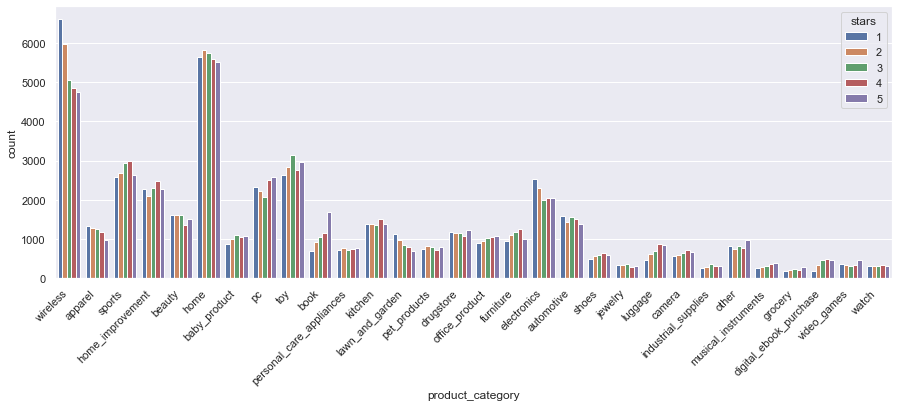

In [15]:
# Visualización
plt.figure(figsize=(15,5))
grafico = sns.countplot(x=data['product_category'],data=data, hue='stars')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

#### 3. ¿Cuál es el promedio de estrellas por cada categoría? <br>
*La media debería dar alrededor de 3, pero aquellos que estén por debajo significa que fueron en su mayoría peor calificados. Inversamente sucede con los que están por encima de 3, lo que significa que fueron en su mayoría muy bien calificados.*

In [16]:
# Promedio de estrellas por categoría ordenados de forma ascendente
from statistics import mean
data_grouped = data.stars.groupby([data['product_category']]).mean().reset_index(name='avg_stars')
data_grouped['rev_count'] = data.stars.groupby([data['product_category']]).count().astype(int).reset_index(name='rev_count').rev_count
data_grouped.sort_values(by='avg_stars')

,product_category,avg_stars,rev_count
16,lawn_and_garden,2.763093,4449
29,wireless,2.821523,27208
0,apparel,2.869638,6014
8,electronics,2.891091,10899
14,jewelry,2.929636,1677
3,beauty,2.940574,7707
1,automotive,2.955704,7495
11,home,2.982526,28328
28,watch,2.994895,1567
23,pet_products,2.996409,3899


##### Visualización

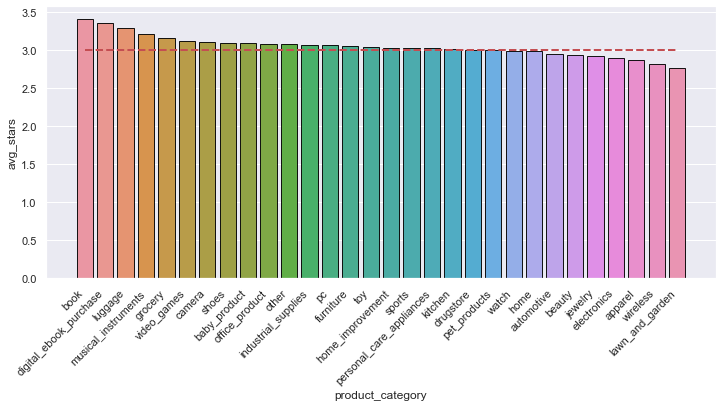

In [17]:
# Visualización de valoración promedio por categoría
data_grouped.sort_values(['avg_stars','rev_count'],ascending=False,inplace=True)
cte = np.ones(data_grouped.shape[0])*3 # Valor medio
plt.figure(figsize=(12,5))
grafico = sns.barplot(x=data_grouped.product_category, y=data_grouped.avg_stars, linewidth=0.9,edgecolor=(0,0,0))
plt.plot(cte, ls = '--', lw = 2, c='r',label = 'Valoración media')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

#### 4. ¿Cuántas reseñas hay por cada categoría? <br>
*Esto nor permitirá dar contexto a los promedios previamente obtenidos.*

<AxesSubplot:title={'center':'Cantidad de reviews por categoría'}, xlabel='Categoría', ylabel='Cantidad de reseñas'>

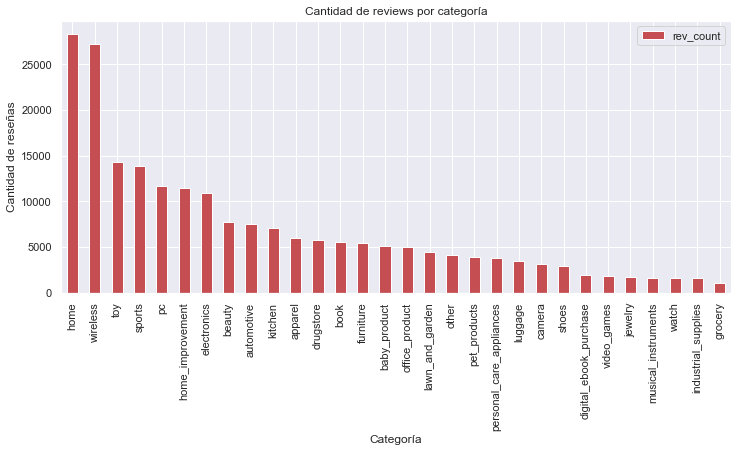

In [18]:
data_grouped.sort_values(by='rev_count',ascending=False).plot(x='product_category',y='rev_count',kind='bar',figsize=(12,5),title='Cantidad de reviews por categoría', xlabel='Categoría', ylabel='Cantidad de reseñas', color= 'r')

#### 5. ¿Cuántas reviews hay por cada valoración?

In [19]:
data.stars.value_counts()

1    42000
2    42000
3    42000
4    42000
5    42000
Name: stars, dtype: int64

*Vemos que está equilibrada la cantidad de cada una.*

#### 6. ¿Cuántos usuarios únicos publicaron en este dataset?

In [20]:
# Ver cuántos usuarios únicos publicaron
unique_usrs = len(data.reviewer_id.unique())
print("En total escribieron" + color.BOLD, unique_usrs, color.END + "usuarios únicos de las" + color.BOLD, data.shape[0],color.END + "reseñas existentes.")
print("Esto equivale al" + color.CYAN, unique_usrs*100//data.shape[0], "%" + color.END)

En total escribieron 187140 usuarios únicos de las 210000 reseñas existentes.
Esto equivale al 89 %


#### 7. ¿Cuántos productos únicos aparecen en las reseñas?

In [21]:
# Ver sobre cuántos productos únicos se publicaron reseñas
unique_prods = len(data.product_id.unique())
print("De las" + color.BOLD, data.shape[0],color.END + "reseñas, se mencionan" + color.BOLD, unique_prods , color.END + "productos únicos.")
print("Esto equivale al" + color.CYAN, unique_prods*100//data.shape[0], "%" + color.END)

De las 210000 reseñas, se mencionan 156458 productos únicos.
Esto equivale al 74 %


#### 8. Tomamos como ejemplo un usuario y analizamos su actividad

In [22]:
# Vemos las reseñas de un solo usuario
rand_idx = np.random.randint(0,data.shape[0])
usr = data.reviewer_id.iloc[rand_idx]
usr_data = data[data.reviewer_id == usr]
print("Cantidad de reseñas del usuario" + color.BOLD, usr,color.END + ":", len(usr_data))
print("Promedio de estrellas que ha dado:" + color.YELLOW, usr_data.stars.mean(),color.END)
usr_data[['reviewer_id','product_category','review_title','review_body','stars']]

Cantidad de reseñas del usuario reviewer_es_0473711 : 1
Promedio de estrellas que ha dado: 3.0 


,reviewer_id,product_category,review_title,review_body,stars
94069,reviewer_es_0473711,apparel,barita rota,"el vestido bastante bien, a mi hija le gusto, ...",3


In [23]:
print(color.BOLD + "Título:" + color.END,usr_data.review_title.iloc[0])
print(color.BOLD + "Reseña:" + color.END,usr_data.review_body.iloc[0])

Título: barita rota
Reseña: el vestido bastante bien, a mi hija le gusto, pero fue una decepcion para ella que la barita le llegara rota, las piedras de la corona, collar y la barita ya las hemos puesto cola porque se han caído el primer dia.


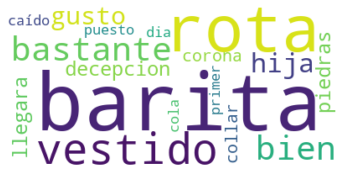

In [24]:
# pip install wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',stopwords=stopwords_nltk).generate(usr_data.review_title.iloc[0] + ' ' + usr_data.review_body.iloc[0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

*Con una review no es tan eficiente el Wordcloud para visualizar ya que puede no haber palabras repetidas. Buscamos entonces juntar más reviwes de un mismo tipo*

#### 9. ¿Cuáles son las palabras más frecuentes por cada valoración?
Para responder a esto utilizmos la librería spaCy para el procesamiento del lenguaje natural.

In [25]:
# Separamos en distintos dataframes las reviews según valoración
data_star_1 = data[data['stars']==1]
data_star_2 = data[data['stars']==2]
data_star_3 = data[data['stars']==3]
data_star_4 = data[data['stars']==4]
data_star_5 = data[data['stars']==5]

<span style='color:purple;'>**Empezamos analizando las reviews de 1 estrella:**</span>
<br> Vamos a quedarnos sólo con los adjetivos para mejorar la visualización. <br>(8 min)

In [26]:
todas_reviews_1 = []
for i in data_star_1.index:
    review1 = data_star_1.review_body[i] #seleccionar el titular
    sent = nlp(review1.lower())
    for token in sent:
        if (token.pos_ == "ADJ" and token.text not in stopwords_spacy and len(token.text)>2):
            temp = token.lemma_
            todas_reviews_1.append(temp) #agregar el resultado a la lista

print('- Cantidad de palabras filtradas:' + color.BOLD,len(todas_reviews_1), color.END)
todas_reviews_1[:3]

- Cantidad de palabras filtradas: 70769 


['malisimo', 'grande', 'aparatoso']

In [27]:
# Obtenemos frecuencia de palabras y creamos nuevo df
freq_rev_1 = nltk.FreqDist(todas_reviews_1)
df_rev_frec_1 = pd.DataFrame(freq_rev_1.items(), columns = ['Palabra', 'Frecuencia']) 
df_rev_frec_1.sort_values(by=['Frecuencia'], inplace=True, ascending=False)
df_rev_frec_1.reset_index(drop = True, inplace=True)
df_rev_frec_1.head()

,Palabra,Frecuencia
0,malo,3750
1,pequeño,1890
2,roto,1530
3,amazon,1157
4,buen,915


In [28]:
# Vemos la parte inferior
df_rev_frec_1[df_rev_frec_1['Frecuencia']<10]

,Palabra,Frecuencia
850,tocado,9
851,caido,9
852,pequeñísimo,9
853,porfavor,9
854,justito,9
...,...,...
5858,arcon,1
5859,tintada,1
5860,ténue,1
5861,ronpio,1


##### Visualizamos la frecuencia de las palabras en las reviews de 1 estrella

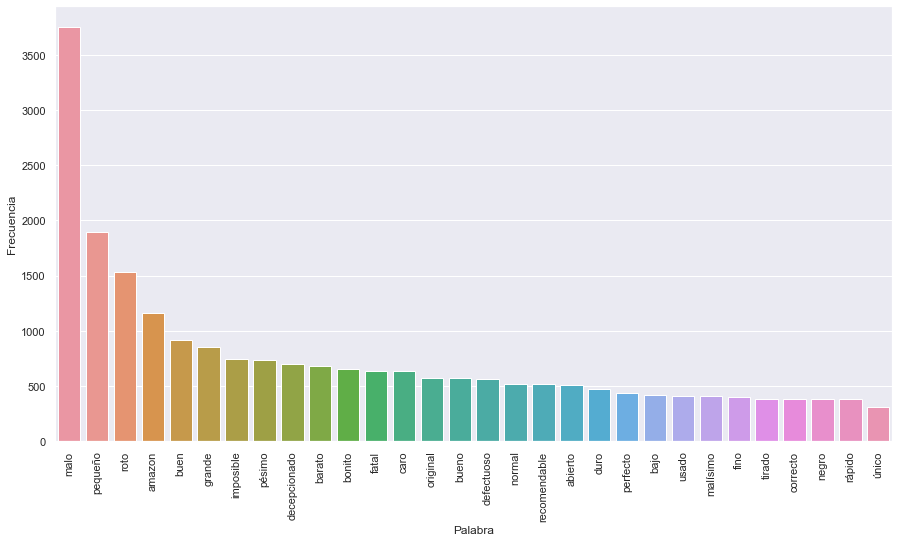

In [29]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_1.iloc[:30].Palabra, y = df_rev_frec_1.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

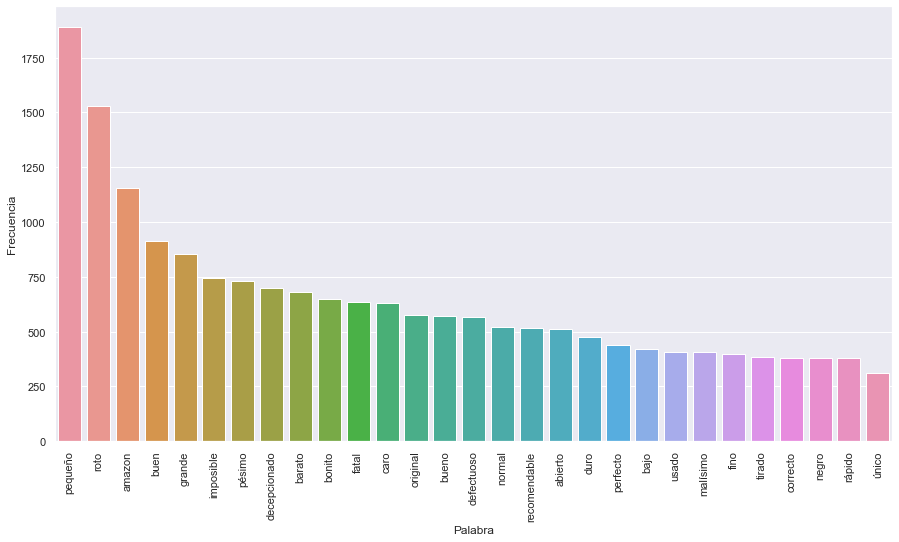

In [30]:
# Filtramos la palabra 'no' que es ampliamente más frecuente para visualizar mejor
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_1.iloc[1:30].Palabra, y = df_rev_frec_1.iloc[1:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [31]:
from wordcloud import WordCloud

# Definimos función para ver el wordcloud de una lista de palabras
def ver_wordcloud(palabras):
    text = ' '.join(palabras)
    wordcloud = WordCloud(background_color='white',width=900,height=450).generate(text.strip())
    plt.figure(figsize = (15,8), facecolor = None)
    plt.imshow(wordcloud, interpolation='kaiser')
    plt.axis("off")
    plt.show()

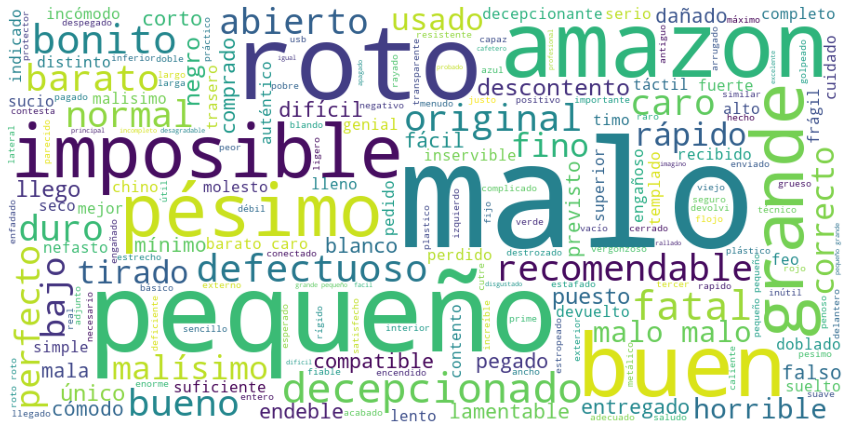

In [32]:
ver_wordcloud(todas_reviews_1)

*Palabras como 'bonito', 'recomendable' y 'perfecto' se repiten mucho pero seguramente sea porque están en un contexto negativo y las niegan.*

*'Amazon' también se repite y podemos suponer que es por el enojo o la decepción que nombran a la empresa.*

##### Abstracción
Para procesar los restantes dataframes, abstraemos todas las operaciones en dos funciones:

In [33]:
def adj_list(dataframe):
    todas_reviews = []
    for i in dataframe.index:
        review1 = dataframe.review_body[i] #seleccionar el titular
        sent = nlp(review1.lower())
        # review1 = RegexpTokenizer('\w+').tokenize(review1) # Tokenizar con RegexpTokenizer
        for token in sent:            
            if (token.pos_ == "ADJ" and str(token) not in stopwords_spacy and len(token.text)>2):
                temp = token.lemma_
                todas_reviews.append(temp) #agregar el resultado a la lista
    return todas_reviews

def adj_frecquency_df(todas_reviews):
    # plain_todas_reviews = list(itertools.chain(*todas_reviews)) # Aplanar la lista
    freq_revs = nltk.FreqDist(todas_reviews) # Obtener frecuencia por palabra
    df_revs = pd.DataFrame(freq_revs.items(), columns = ['Palabra', 'Frecuencia']) # Crear nuevo df
    df_revs.sort_values(by=['Frecuencia'], inplace=True, ascending=False) # Ordenar valores por frecuencia
    df_revs.reset_index(drop = True, inplace=True) # Resetear index
    return df_revs

<span style='color:purple;'>**Analizamos las reviews de 5 estrellas:**</span> <br>
(8 min)

In [34]:
# Listamos los adjetivos de las reviews con 5 estrellas
todas_reviews_5 = adj_list(data_star_5)

In [35]:
df_rev_frec_5 = adj_frecquency_df(todas_reviews_5)
df_rev_frec_5

,Palabra,Frecuencia
0,perfecto,7180
1,buen,7157
2,fácil,2720
3,bonito,2674
4,genial,2592
...,...,...
6002,disfrutable,1
6003,suavizante,1
6004,selfie-tripode,1
6005,procedi,1


##### Visualizamos la frecuencia de las palabras en las reviews de 5 estrellas

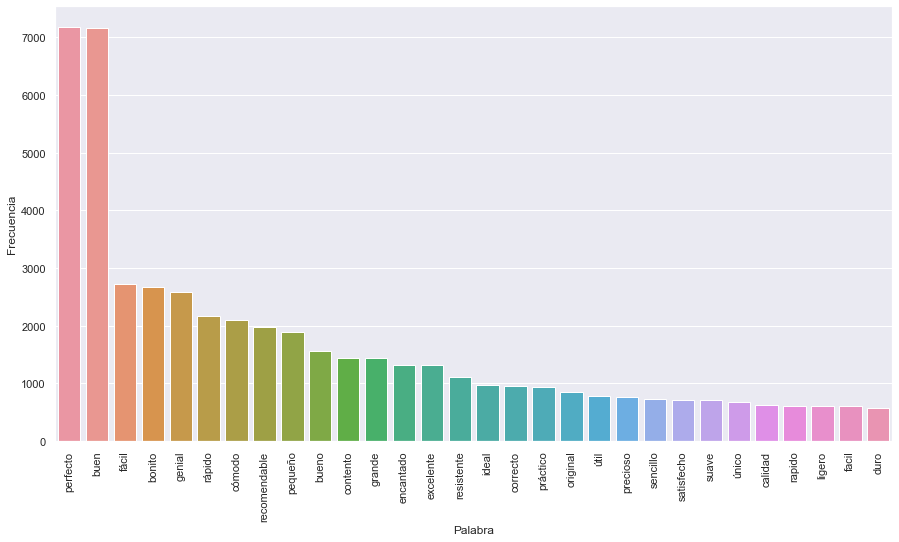

In [36]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_5.iloc[:30].Palabra, y = df_rev_frec_5.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

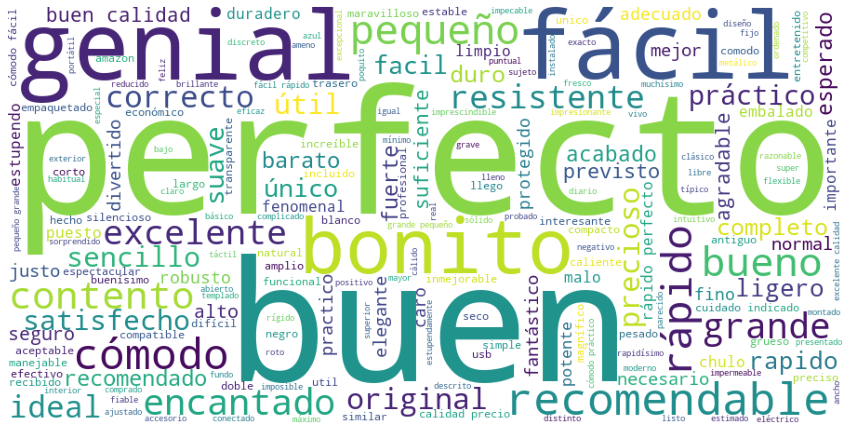

In [37]:
ver_wordcloud(todas_reviews_5)

<span style='color:purple;'>**Como punto medio, analizamos las reviews de 3 estrellas:**</span> <br>
(8 min)

In [38]:
# Listamos los adjetivos de las reviews con 3 estrellas
todas_reviews_3 = adj_list(data_star_3)

In [40]:
df_rev_frec_3 = adj_frecquency_df(todas_reviews_3)
df_rev_frec_3

,Palabra,Frecuencia
0,pequeño,3714
1,buen,3356
2,bonito,2449
3,grande,2314
4,bueno,1762
...,...,...
6312,conclusión,1
6313,adornado,1
6314,ios,1
6315,enrosco,1


##### Visualizamos la frecuencia de las palabras en las reviews de 3 estrellas

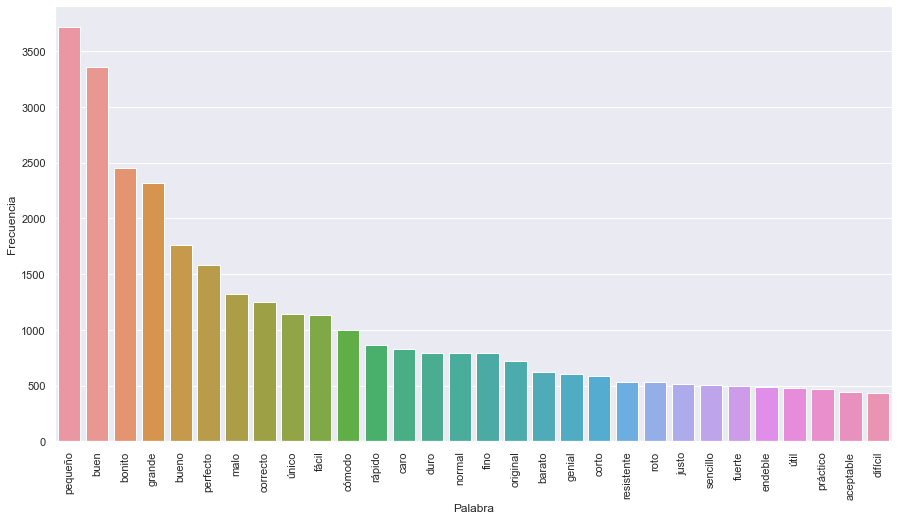

In [41]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_3.iloc[:30].Palabra, y = df_rev_frec_3.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

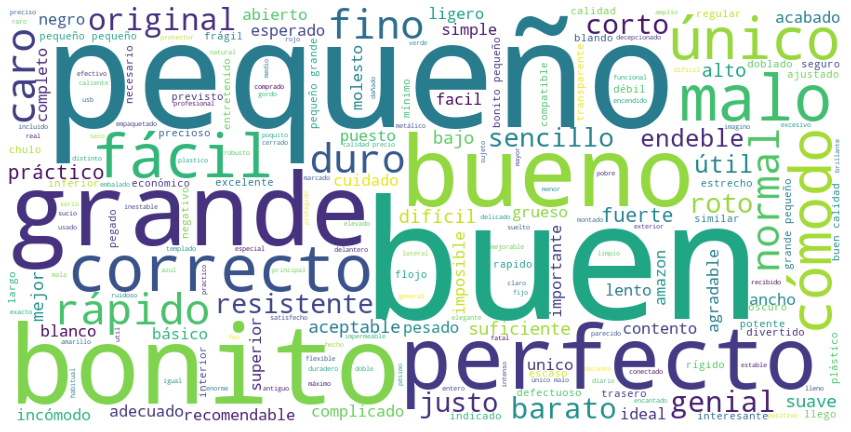

In [42]:
ver_wordcloud(todas_reviews_3)

In [43]:
# Liberamos espacio de memoria
del(data_grouped)
del(data_star_1)
del(data_star_2)
del(data_star_3)
del(data_star_4)
del(data_star_5)
del(todas_reviews_1)
del(todas_reviews_3)
del(todas_reviews_5)
del(df_rev_frec_1)
del(df_rev_frec_3)
del(df_rev_frec_5)
del(data)
gc.collect()

11764

## Preprocesamiento
### Importamos el dataset de entrenamiento
Importamos dataset que será utilizado para *train* y nos quedamos con las columnas relevantes.

<span style='color:red;'>**!! ACLARACIÓN:** En el notebook de <a href='https://github.com/lusalmeron/Proyecto-3-NLP/blob/main/Procesamiento_de_datasets.ipynb'>"Procesamiento_de_datasets"</a> se muestra el trabajo realizado para llegar a un único dataset filtrado por las columnas relevantes y que contengan también las lemmatizaciones y stemmizaciones de cada review concatenada a su título. **Ése es el set de datos que importamos para ahorrar tiempo de ejecución.**</span>

In [174]:
# Importamos dataset limpio
data = pd.read_json("dataset_amazon_clean.json", lines = False)
print("- Cantidad de filas " + color.BOLD + "total" + color.END + " del set:", data.shape[0])
print("- Cantidad de filas " + color.BOLD + "nulas" + color.END + " por columna:")
data.isna().sum()

- Cantidad de filas total del set: 210000
- Cantidad de filas nulas por columna:


product_category    0
review_title        0
review_body         0
stars               0
revs_lemma          0
revs_stem           0
dtype: int64

### Tokenización 
Si bien el dataset ya está limpio, tomamos una review al azar y aplicamos funciones y objetos de la librería spaCy para explorarlos.

In [46]:
# Miramos una review al azar
random_index = np.random.randint(0,data.shape[0])
review = data.review_body.iloc[random_index]
title = data.review_title.iloc[random_index]
print(color.BOLD + '- ID:' + color.END, random_index,'\n' + color.BOLD + '- Título:' + color.END,title,'\n' + color.BOLD + '- Reseña:' + color.END, review)
print(color.BOLD + '- Valoración:' + color.END,data.stars[random_index])
print(color.BOLD + '- Categoría:' + color.END, data.product_category[random_index])

- ID: 199274 
- Título: Ninos 3 años 
- Reseña: Esta muy bien aunq lo vamos a guardar un añito mas
- Valoración: 5
- Categoría: toy


In [47]:
# Mostramos las POS de la review elegida
sent = nlp(review)
print("{0:20}{1:20}".format("PALABRA:","POS:"))
for token in sent:
    print("{0:20}{1:20}".format(token.text,token.pos_))

PALABRA:            POS:                
Esta                DET                 
muy                 ADV                 
bien                ADV                 
aunq                VERB                
lo                  PRON                
vamos               AUX                 
a                   ADP                 
guardar             VERB                
un                  DET                 
añito               NOUN                
mas                 ADV                 


In [48]:
# Visualización de los POS
from spacy import displacy
displacy.render(sent, style="dep")

### Lemmatizer
Analizamos esta función de la librería spaCy con la review al azar.

In [49]:
# Tokens lemmatizados de la review elegida
print("{0:20}{1:20}{2:20}".format("PALABRA:","POS:","LEMMA:"))
for token in sent:
    print("{0:20}{1:20}{2:20}".format(token.text,token.pos_,token.lemma_))

PALABRA:            POS:                LEMMA:              
Esta                DET                 este                
muy                 ADV                 mucho               
bien                ADV                 bien                
aunq                VERB                aunq                
lo                  PRON                él                  
vamos               AUX                 ir                  
a                   ADP                 a                   
guardar             VERB                guardar             
un                  DET                 uno                 
añito               NOUN                añito               
mas                 ADV                 mas                 


In [54]:
#Función para limpieza de datos con lemmatizer
def text_data_lemma(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ not in excluded_pos and str(token) not in stopwords_spacy and len(token.text)>2): 
            temp = token.lemma_.strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

In [55]:
# Lemmatizamos y filtramos la review escogida
print(color.BOLD + "[ REVIEW ORIGINAL ] :" + color.END, review)
clean_review = text_data_lemma(review)
clean_review = " ".join(clean_review)
print(color.BOLD + "\n[ REVIEW LEMMATIZADA ] :" + color.END, clean_review)

[ REVIEW ORIGINAL ] : Esta muy bien aunq lo vamos a guardar un añito mas

[ REVIEW LEMMATIZADA ] : bien aunq guardar añito


### Stemmizer
Analizamos esta función de la librería spaCy con la review al azar.

In [56]:
# Importamos objeto de nltk que nos permite stemmizar en español
from nltk.stem.snowball import SpanishStemmer
stemmer = SpanishStemmer()

In [57]:
# Porbamos el stemmer en review al azar
sent = nlp(review)
print("{0:20}{1:20}{2:20}".format("PALABRA:","POS:","STEM:"))
for token in sent:
    print("{0:20}{1:20}{2:20}".format(token.text,token.pos_,stemmer.stem(token.text)))

PALABRA:            POS:                STEM:               
Esta                DET                 esta                
muy                 ADV                 muy                 
bien                ADV                 bien                
aunq                VERB                aunq                
lo                  PRON                lo                  
vamos               AUX                 vam                 
a                   ADP                 a                   
guardar             VERB                guard               
un                  DET                 un                  
añito               NOUN                añit                
mas                 ADV                 mas                 


In [59]:
# Función para limpieza de datos con stemmer
def text_data_stem(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ not in excluded_pos and str(token) not in stopwords_spacy and len(token.text)>2): 
            temp = stemmer.stem(token.text).strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

In [60]:
# Filtramos y stemmizamos la review escogida
print(color.BOLD + "[ REVIEW ORIGINAL ] :" + color.END, review)
clean_review = text_data_stem(review)
clean_review = " ".join(clean_review)
print(color.BOLD + "\n[ REVIEW STEMMIZADA ] :" + color.END, clean_review)

[ REVIEW ORIGINAL ] : Esta muy bien aunq lo vamos a guardar un añito mas

[ REVIEW STEMMIZADA ] : bien aunq guard añit


In [61]:
gc.collect()

78056

<span style='color:blue;'> *Como el proceso de lemmatizar y stemmizar las reviews ya está hecho y agregado al dataset, pasamos a lo siguiente: la **vectorización**.*</span>

## Vectorización
### Importar y crear vectorizador

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_features=50000 # Determina máximo de palabras que toma para hacer la matriz
min_df = 0.01 # Toma todas las palabras que tengan un mpinimo de frecuencia del 0.01

tfidf = TfidfVectorizer(max_features=max_features, min_df=min_df)

### Separamos datasets lemma y stem

In [175]:
# Columnas de interés del dataset LEMMA
data.loc[:,('revs_lemma','stars')].head()

,revs_lemma,stars
0,malo compro malisimo grande aparatoso protecto...,1
1,recibir recibir pedido devolución,1
2,apretar manillar tener buscar sistema funciona...,1
3,brocas mantequilla utilicé broca menor diámetr...,1
4,gustar gustar olor viejo aspecto malo,1


In [65]:
# Columnas de interés del dataset STEM
data.loc[:,('revs_stem','stars')].head()

,revs_stem,stars
0,mal compr malisim grand aparat protector pantall,1
1,recib recib ped devolu,1
2,apriet manill teng busc sistem funcion abrazad...,1
3,broc mantequill utilic broc menor diametr dobl...,1
4,gust gust olor viej aspect mal,1


Probamos primero con las reviews **lemmatizadas**, pero bien podría cambiarse por las **stemmizadas** comentando y descomentando líneas.

In [107]:
## LEMMA
# list_revs = list(data['revs_lemma'].values)
# stars = data['stars'].values

## STEM
list_revs = list(data['revs_stem'].values)
stars = data['stars'].values

list_revs[:5]

['mal compr malisim grand aparat protector pantall',
 'recib recib ped devolu',
 'apriet manill teng busc sistem funcion abrazader agarr manill apriet desliz lintern abaj',
 'broc mantequill utilic broc menor diametr dobl fues mantequill minim presion dobl enderez part exterior amarill interior fund gris compr',
 'gust gust olor viej aspect mal']

### Train-Test split de los datos
Usaremos el 70% para entrenamiento y el 30% para prueba. Luego vectorizaremos cada set por separado para evitar *data leaks*.

In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(list_revs,stars,test_size=0.3,random_state=42,stratify=stars)
print("- Tamaño del set de " + color.CYAN + "entrenamiento:" + color.BOLD, len(X_train), color.END)
print("- Tamaño del set de " + color.GREEN + "prueba:" + color.BOLD, len(X_test),color.END)
print("- Algunos " + color.BOLD + "ejemplos" + color.END + " del set de entrenamiento:")
X_train[:5]

- Tamaño del set de entrenamiento: 147000 
- Tamaño del set de prueba: 63000 
- Algunos ejemplos del set de entrenamiento:


['perfect naveg multimedi teng potenci salon habit quier silenci ocup poquisim espaci suficient soltur naveg vide youtub consult red social bast sobr',
 'fragil agujere dia flot piscin roz bord unic posibil accident',
 'cumpl expect sencill comod util necesari cam nid',
 'pequeñ gat genial perr pequeñ',
 'servici lament amazon correct product tuv esper seman fech inicial entreg lleg reclam amazon unic solucion esper cancel ped lament']

### Generación de la matriz

In [109]:
# Ajustamos el vectorizador y transformamos los datos de entrenamiento
matriz_train = tfidf.fit_transform(X_train)
matriz_train

<147000x204 sparse matrix of type '<class 'numpy.float64'>'
	with 825006 stored elements in Compressed Sparse Row format>

In [110]:
# Vemos las palabras utilizadas (ordenadas alfabéticamente)
all_words = tfidf.get_feature_names()
print("Palabras más usadas:",all_words[:150])

Palabras más usadas: ['acab', 'acept', 'adapt', 'ademas', 'agu', 'aguant', 'ajust', 'amazon', 'articul', 'años', 'baj', 'barat', 'bat', 'bien', 'bols', 'bonit', 'boton', 'buen', 'busc', 'cabl', 'caj', 'calid', 'calidad', 'cam', 'cambi', 'car', 'carg', 'cas', 'coch', 'coloc', 'color', 'comod', 'complet', 'compr', 'conect', 'contact', 'content', 'corre', 'correct', 'cort', 'cos', 'cre', 'cristal', 'cubr', 'cuest', 'cuid', 'cumpl', 'decepcion', 'defectu', 'dej', 'descripcion', 'despeg', 'devolu', 'devolv', 'devuelt', 'dia', 'dias', 'dificil', 'diner', 'diseñ', 'dobl', 'dud', 'dur', 'encaj', 'encant', 'entreg', 'envi', 'esper', 'estrell', 'excelent', 'expect', 'facil', 'fall', 'falt', 'fech', 'fin', 'form', 'fot', 'fuert', 'funcion', 'fund', 'general', 'genial', 'graci', 'grand', 'gust', 'hac', 'hij', 'hor', 'ideal', 'imag', 'indic', 'instal', 'instruccion', 'jueg', 'just', 'libr', 'liger', 'limpi', 'lleg', 'llev', 'luz', 'mal', 'man', 'mand', 'marc', 'material', 'med', 'mejor', 'mes', 'me

In [111]:
# Transformamos los datos de prueba en base al vectorizador ya entrenado
matriz_test = tfidf.transform(X_test)
matriz_test

<63000x204 sparse matrix of type '<class 'numpy.float64'>'
	with 351700 stored elements in Compressed Sparse Row format>

## Modelización

In [71]:
# Importamos modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [112]:
xtrain = matriz_train.toarray()
xtest = matriz_test.toarray()

# Para la validación cruzada neceitamos el set entero
X = tfidf.transform(list_revs)
X = X.toarray()
y = stars

#### Métricas de evluación

In [73]:
from sklearn.metrics import classification_report # Para un reporte con precision, recall y f1_score
from sklearn.metrics import accuracy_score

Vamos a utilizar el **accuracy score** para evaluar en general la precisión del multiclasificador, ya que genera un promedio entre todas las clases (que en nuestro dataset están balancedas en cantidad) y hace un ajuste entre *precisión* y *recall*. 

Como complemento, utilizaremos el **Calssification report** para ver cómo varían la precisión y el recall por clase.

También elaboramos función para visualizar la **matriz de confusión** de cada modelo.

In [74]:
from sklearn.metrics import confusion_matrix

def confusion(ytest,y_pred):
    names=["1 star","2 stars","3 stars","4 stars","5 stars"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Validación cruzada

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

def k_validacion_cruzada(model,x,y,k):
    scores = cross_val_score(model, x, y, cv=k)
    print("%0.2f de precisión con desviación estándar de %0.2f" % (scores.mean(), scores.std()))

### Naive Bayes - Modelo Benchmark

In [113]:
nb = GaussianNB()
nb.fit(xtrain,ytrain)

y_pred = nb.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END, accuracy_score(ytest,y_pred))

Accuracy :  0.4146666666666667


In [95]:
print(color.BOLD + 'Validación cruzada:' + color.END)
k_validacion_cruzada(nb,X,stars,5)

Validación cruzada:
0.41 de precisión con desviación estándar de 0.00


In [96]:
print(color.BOLD + 'Reporte de clasificación : '+ color.END + '\n \n' ,classification_report(ytest, y_pred, target_names=['1','2','3','4','5']))

Reporte de clasificación : 
 
               precision    recall  f1-score   support

           1       0.45      0.71      0.55     12600
           2       0.35      0.25      0.29     12600
           3       0.35      0.19      0.25     12600
           4       0.39      0.22      0.28     12600
           5       0.42      0.67      0.52     12600

    accuracy                           0.41     63000
   macro avg       0.39      0.41      0.38     63000
weighted avg       0.39      0.41      0.38     63000



*Las métricas del reporte se ven explicadas en la matriz de confusión.*

Matriz de confusión : 


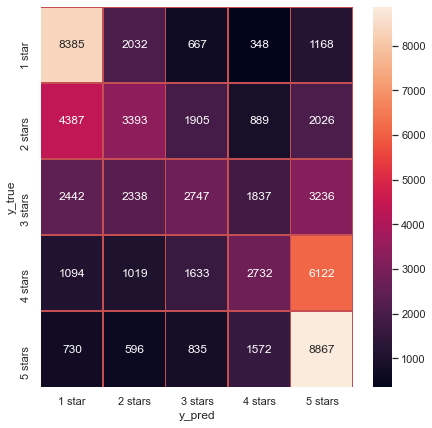

In [114]:
print(color.BOLD + 'Matriz de confusión : '+ color.END)
confusion(ytest,y_pred)

*Vemos que los mayores aciertos están en las de 1 y 5 estrellas. Aún así, existen bastantes de 5 estrellas que predijo como de 1. Esto podría deberse a que usan palabras parecidas, tanto para hablar positivamente como diciendo que "no" son así.*

*También vemos que hay gran confusión también entre los de 4 y 5 estrellas y los de 1 y 2 estrellas. Es entendible porque hay mucho parecido entre ellas.*

*Finalmente, el de 3 estrellas es el que más fácilmente se confunde con los demás ya que es la media y tiene palabras que se repiten en todas las reseñas.*

### Random Forest

In [98]:
rf = RandomForestClassifier()
rf.fit(xtrain,ytrain)

y_pred = rf.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END, accuracy_score(ytest, y_pred))

Accuracy :  0.42758730158730157


In [99]:
print(color.BOLD + 'Validación cruzada:' + color.END)
k_validacion_cruzada(rf,X,stars,5)

Validación cruzada:
0.43 de precisión con desviación estándar de 0.00


In [100]:
print(color.BOLD + 'Reporte de clasificación : '+ color.END + '\n \n' ,classification_report(ytest, y_pred, target_names=['1','2','3','4','5']))

Reporte de clasificación : 
 
               precision    recall  f1-score   support

           1       0.53      0.61      0.56     12600
           2       0.35      0.32      0.33     12600
           3       0.33      0.32      0.32     12600
           4       0.38      0.34      0.36     12600
           5       0.51      0.55      0.53     12600

    accuracy                           0.43     63000
   macro avg       0.42      0.43      0.42     63000
weighted avg       0.42      0.43      0.42     63000



*Las métricas del reporte se ven explicadas en la matriz de confusión.*

Matriz de confusión : 


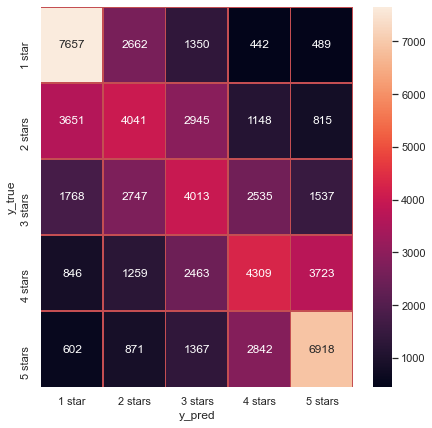

In [101]:
print(color.BOLD + 'Matriz de confusión : '+ color.END)
confusion(ytest,y_pred)

*Se nota una mejora ocnsiderable en la identificación de cada clase, e incluso se redujo en un buen porcentaje la confusión entre los extremos 1-2 y 4-5.*

*También mejoró la distinción entre 5 y 1, lo mismo que se ajustó la predicción de los 3: ya no hay tanta confusión con las demás clases.*

#### Feature importances
Algo muy bueno de Random Forest es que puede indicar la importancia de los features que se usan para clasificar. Veamos en este caso cuáles son las palabras que mayormente determinan el el valor de una review para este clasificador.

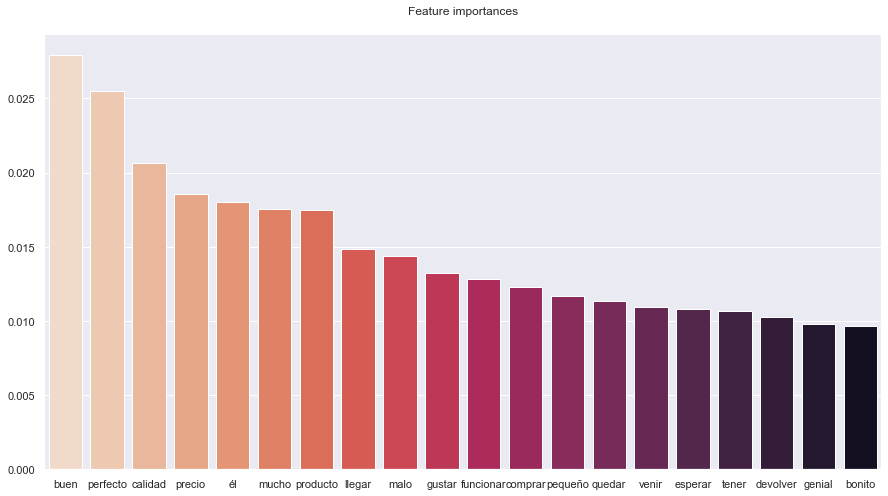

In [102]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = tfidf.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices] # 
selected_importances = importances[indices] # 

# Por ultimo graficamos
plt.figure(figsize = (15,8))
plt.title(label='Feature importances',pad=20)
sns.barplot(x=selected_columns, y=selected_importances,palette='rocket_r')
plt.show()

### SVM

In [103]:
# En vez de utilizar SVC, vamos a usar LinearSVC, 
# ya que para el Kernel Lineal esta función es MUCHO mas rapida que la tradicional SVC.

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)

y_pred = svc.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END, accuracy_score(ytest, y_pred))

Accuracy :  0.44536507936507935


In [104]:
print(color.BOLD + 'Validación cruzada:' + color.END)
k_validacion_cruzada(svc,X,stars,5)

Validación cruzada:
0.45 de precisión con desviación estándar de 0.00


In [105]:
print(color.BOLD + 'Reporte de clasificación : '+ color.END + '\n \n' ,classification_report(ytest, y_pred, target_names=['1','2','3','4','5']))

Reporte de clasificación : 
 
               precision    recall  f1-score   support

           1       0.51      0.69      0.59     12600
           2       0.37      0.30      0.33     12600
           3       0.35      0.30      0.32     12600
           4       0.42      0.32      0.36     12600
           5       0.51      0.63      0.56     12600

    accuracy                           0.45     63000
   macro avg       0.43      0.45      0.43     63000
weighted avg       0.43      0.45      0.43     63000



*Las métricas del reporte se ven explicadas en la matriz de confusión.*

Matriz de confusión : 


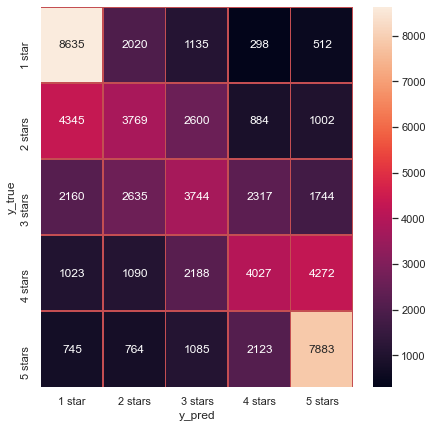

In [106]:
print(color.BOLD + 'Matriz de confusión : '+ color.END)
confusion(ytest,y_pred)

*Si bien mejora considerablemente la predicción en los extremos, empeora respecto del random forest en las predicciones de la clase de 3 estrellas. En los casos de las falsas predicciones de 1 y 5 para reviews que son de 3 puede suponerse que es porque son ambiguas y no logra identificar a cuál extremo pertenecen, por lo que les asigna un punto medio.*

### Comparación modelos `Lemma` vs `Stem`

- El benchmark con el dataset lemmatizado tiene casi el mismo rendimiento con las clases 1 y 5 que el SVM Lineal con el dataset stemmizado. Pero en las clases intermedias lo supera ampliamente este último.
- Random Forest es apenas más preciso con el dataset stemmizado que con el lemmatizado. Sin embargo, empeora su recall.
- El SVC, en ambos casos, es el que tiene el mejor rendimiento. Pero analizando en profundidad, el SVC con el dataset stem tiene mejor precisión y recall en todas las clases.

La comparación más extensiva está en este documento: <https://github.com/lusalmeron/Proyecto-3-NLP/blob/main/Comparacion_lemma_stem_v2.pdf>

### Conclusión: SVC con dataset stem
Por su rendimiento general y en cada clase en partiuclar, buscaremos optimizar este modelo para aumentar su accuracy.

## Optimización de hiperparámetros del SVC
Para encontrar los valores que maximizan el rendimiento del modelo, vamos a realizar la optimización tanto del SVC como del Vectorizador, ya que las palabras utilizadas para la clasificación influyen en el desempeño del modelo.

Para el vectorizador utilizaremos la **estartegia manual** para encontrar el mínimo valor de frecuencia de palabras (`max_df`) que filtre a las que serán utilizadas para la vectorización.

En cambio, para optimizar el modelo utilizaremos **Grid Search** y encontraremos los valores de `C` y el `kernel` que maximicen su accuracy.

### Búsqueda manual
#### Vectorizer

In [123]:
scores_train = []
scores_test = []
max_features = 15000
list_min_df = [0.00001,0.0001,0.0005,0.001,0.01]
svc = LinearSVC(C = 1)

for value in list_min_df:
    tfidfop = TfidfVectorizer(max_features=max_features, min_df=value)
    mxtrain = tfidfop.fit_transform(X_train)
    mxtest = tfidfop.transform(X_test)
    
    xtrain = mxtrain.toarray()
    xtest = mxtest.toarray()
    
    svc.fit(xtrain,ytrain)
    
    y_pred_train = svc.predict(xtrain)
    y_pred_test = svc.predict(xtest)
    
    scores_train.append(accuracy_score(ytrain, y_pred_train))
    scores_test.append(accuracy_score(ytest, y_pred_test))

scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

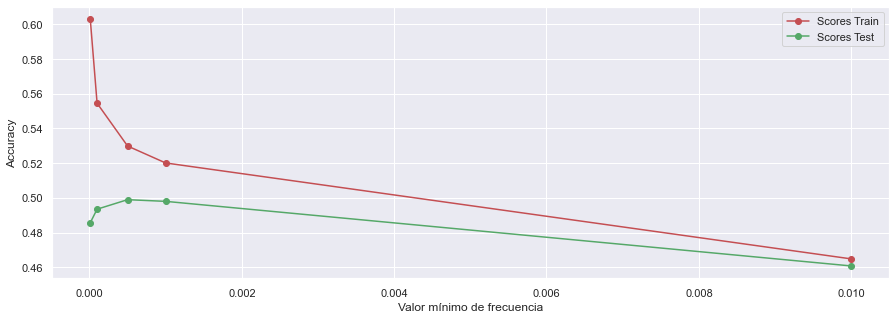

In [124]:
plt.figure(figsize=(15,5))
plt.plot(list_min_df,scores_train,'o-', label = 'Scores Train', c='r')
plt.plot(list_min_df,scores_test,'o-', label = 'Scores Test', c='g')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Valor mínimo de frecuencia')
plt.show()

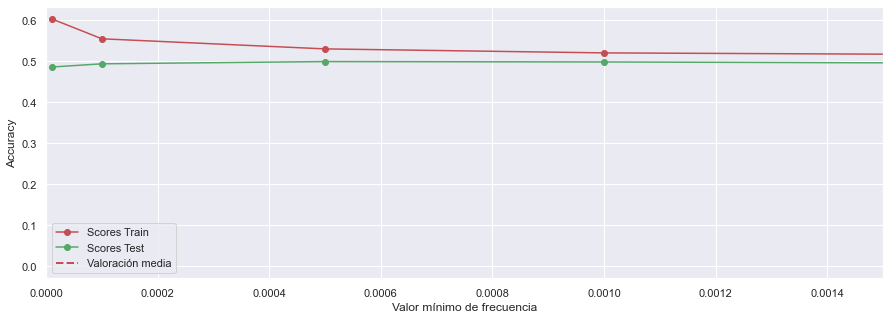

In [126]:
#cte = np.ones(max(scores_train))
plt.figure(figsize=(15,5))
plt.plot(list_min_df,scores_train,'o-', label = 'Scores Train', c='r')
plt.plot(list_min_df,scores_test,'o-', label = 'Scores Test', c='g')
plt.plot(0.001, ls = '--', lw = 2, c='r',label = 'Valoración media')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Valor mínimo de frecuencia')
plt.xlim(0,0.0015)
plt.show()

Haciendo *zoom* en la zona que tiene mayor accuracy en el conjunto de test vemos que fue obtenido con el valor `min_df = 0.001`. Además, es el que menos separado está del accuracy del conjunto de train. Por tanto, éste es el valor óptimo.

Ahora pasamos a optimizar los hiperparámetros del modelo SVC Lineal utilizando el método de Grid Search.

In [151]:
del(mxtrain)
del(mxtest)
del(xtrain)
del(xtest)
del(y_pred_train)
del(y_pred_test)
gc.collect()

23113

### Grid Search
- Pueden ver las búsquedas realizadas y su evaluación en el documento de git: <https://github.com/lusalmeron/Proyecto-3-NLP/blob/main/GridSearchResults.pdf>
#### Optimización del modelo SVC

In [163]:
# Grilla para Grid Search
# param_grid = {'C':[1,1.5,2,2.5,3]}
param_grid = {'C':[0.01,0.1,1,1.1]}

# Grid Search
from sklearn.model_selection import GridSearchCV
svcgs = LinearSVC()
model = GridSearchCV(svcgs, param_grid=param_grid)

In [164]:
# Vectorizador optimizado
tfidfop = TfidfVectorizer(max_features=15000, min_df=0.001)
mxtrain = tfidfop.fit_transform(X_train)
mxtest = tfidfop.transform(X_test)

xtrain = mxtrain.toarray()
xtest = mxtest.toarray()
mxtrain

<147000x1477 sparse matrix of type '<class 'numpy.float64'>'
	with 1398530 stored elements in Compressed Sparse Row format>

In [165]:
# Entrenamiento
model.fit(xtrain, ytrain)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.01, 0.1, 1, 1.1]})

In [166]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores parametros: {'C': 0.01}
Mejor Score: 0.49779591836734693



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.559744,0.072188,0.102507,0.006092,0.01,{'C': 0.01},0.499660,0.498367,0.497347,0.494082,0.499524,0.497796,0.002039,1
1,3.937335,0.183647,0.097143,0.005267,0.10,{'C': 0.1},0.497279,0.498265,0.496293,0.493980,0.498095,0.496782,0.001566,2
2,9.155562,0.020803,0.101543,0.006971,1,{'C': 1},0.494966,0.496429,0.493776,0.493061,0.496259,0.494898,0.001329,4
3,9.753392,0.029683,0.094146,0.001470,1.10,{'C': 1.1},0.495034,0.496497,0.493776,0.493061,0.496259,0.494925,0.001346,3


### Evaluación del modelo optimizado
Los datos se vectorizan con el tfidf con un `mìn_df = 0.001` y `max_features = 15000`.<br>
Luego se entrena un modelo `LinearSVC`con `C = 0.1`.

In [168]:
svcop = LinearSVC(C=0.01)
svcop.fit(xtrain,ytrain)

y_pred = svcop.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END + color.YELLOW, accuracy_score(ytest, y_pred), color.END)

Accuracy :  0.4996507936507936 


In [169]:
print(color.BOLD + 'Reporte de clasificación : '+ color.END + '\n \n' ,classification_report(ytest, y_pred, target_names=['1','2','3','4','5']))

Reporte de clasificación : 
 
               precision    recall  f1-score   support

           1       0.57      0.74      0.64     12600
           2       0.42      0.38      0.40     12600
           3       0.41      0.32      0.36     12600
           4       0.45      0.36      0.40     12600
           5       0.57      0.70      0.63     12600

    accuracy                           0.50     63000
   macro avg       0.48      0.50      0.49     63000
weighted avg       0.48      0.50      0.49     63000



Matriz de confusión : 


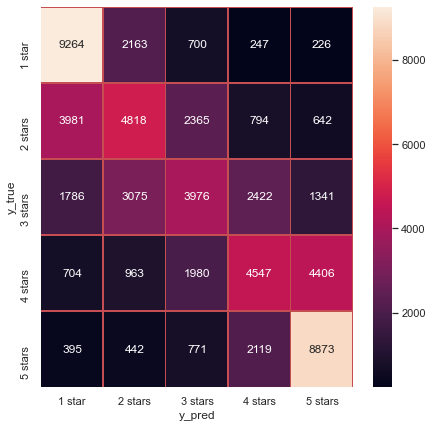

In [170]:
print(color.BOLD + 'Matriz de confusión : '+ color.END)
confusion(ytest,y_pred)

## Conclusión de la optimización
Lo mejor que se pudo obtener con los hiperparámetros óptimos establecidos es una **precisión del 50%**.
Si bien este valor es relativamente bajo, está al límite del rendimiento aceptable, ya que acertará en la mitad de las predicciones de cada clase.

Como vemos en el informe y en la matriz de confusión, los más fáciles de identificar son las clases extremos y los más conflictivos son el 2 y el 4, ya que se los confunde en gran cantidad de casos con el 1 y el 5, respectivamente.

En cuanto a la clase 3, tiene el accuracy más bajo pero es el mejor rendimiento comparado con los otros modelos en esa clase.

In [176]:
# Liberamos espacio en memoria
del(data)
gc.collect()

5677

# Investigación
Como líneas futuras de investigación, para aumentar el rendimiento del modelo, me gustaría:

1. Poder **involucrar las categorías de los productos** para entrenar los modelos, ya que puede haber palabras que tengan más relevancia en una categoría que en otras.
2. Explorar ***[n-gramas](http://www.nltk.org/api/nltk.html?highlight=ngram)* de palabras** para entrenar. Como vimos en las nubes de palabras, las más frecuentes en las clases de 1 y 5 estrellas son parecidas ('bueno', 'perfecto', 'grande', 'recomendable') pero analizar en qué contexto se escriben dichas palabras (las palabras que la acompañan) puede darnos mucha información sobre sis e usa negativa o positivamente. Creo que podría ser muy provechoso para el proyecto.
3. Explorar **pipelines de trabajo** para automatizar los procesos vectorización y entrenamiento. Por las características de la PC que estoy utilizando no me fue podible realizar esto en simultáneo ya que consumía demasiados recursos. Pero con alguna tecnología en la nube o una mejor máquina podría implementarse.
4. Formas de realizar una **limpieza más exahustiva de los datos**, ya que existen casos donde quedaron emojis intercalados con el texto o palabras mal escritas que confunden al modelo e incluso son interpretadas con un diferente POS.

### Si puediera rehacer algo...
#### A- Entrenaría y optimizaría el *random forest stemmizado*
Ya que si bien tiene menor accuracy que el SVM lemma, estaba más equilibrado en cuanto a *precisión* y *recall*.

In [171]:
# Vectorizador optimizado
tfidfop = TfidfVectorizer(max_features=15000, min_df=0.001)
mxtrain = tfidfop.fit_transform(X_train)
mxtest = tfidfop.transform(X_test)

xtrain = mxtrain.toarray()
xtest = mxtest.toarray()

rf = RandomForestClassifier()
rf.fit(xtrain,ytrain)

y_pred = rf.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END + color.YELLOW, accuracy_score(ytest, y_pred), color.END)

Accuracy :  0.4801746031746032 


*Como vemos, habiendo optimizado el vectorizador ya mejora el rendimiento del Random forest haciéndolo pasar de 0.44 de accuracy a **0.48**. Si se hiciera una optimización de hiperparámetros de este modelo, siendo que tiene más parámetros que el SVC, entonces estimo que podríamos incluso superar los 0.499 de precición del SVC.*

#### B- Probaría usar sólo adjetivos, a ver si mejora el desempeño

In [241]:
# Importamos dataset limpio
data = pd.read_json("dataset_amazon_clean.json", lines = False)
data.head()

,product_category,review_title,review_body,stars,revs_lemma,revs_stem
0,wireless,Mala compra,"Malisimo, muy grande demasiado aparatoso y mal...",1,malo compro malisimo grande aparatoso protecto...,mal compr malisim grand aparat protector pantall
1,apparel,No lo he recibido,No he recibido el pedido no la devolución,1,recibir recibir pedido devolución,recib recib ped devolu
2,sports,Que no aprieta bien en el manillar,"Tengo que buscar otro sistema, este no funcion...",1,apretar manillar tener buscar sistema funciona...,apriet manill teng busc sistem funcion abrazad...
3,home_improvement,Brocas de mantequilla,Utilicé las brocas de menor diámetro y se me d...,1,brocas mantequilla utilicé broca menor diámetr...,broc mantequill utilic broc menor diametr dobl...
4,beauty,No me gusta,No me gusta su olor a viejo y aspecto malo,1,gustar gustar olor viejo aspecto malo,gust gust olor viej aspect mal


Analizamos las 10 primeras filas del dataset filtradas por sus adjetivos:

In [245]:
def text_data_lemma(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ == 'ADJ' and str(token) not in stopwords_spacy and len(token.text)>2): 
            temp = token.lemma_.strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

# Limpiamos todas las reviews con lemmatizer
adjs_lemma = []
for i in np.arange(0,11):
    rev = text_data_lemma(data.review_title.iloc[i] + ' ' + data.review_body.iloc[i])
    adjs_lemma.append(" ".join(rev))
adjs_lemma[:10]

['malo compro grande aparatoso',
 '',
 '',
 'menor mínimo doblado amarillo gris',
 'viejo malo',
 'roto roto',
 'imagino aleatorio cesta único',
 'bajo',
 'entregado',
 '']

In [183]:
data.review_body.iloc[:5]

0    Malisimo, muy grande demasiado aparatoso y mal...
1            No he recibido el pedido no la devolución
2    Tengo que buscar otro sistema, este no funcion...
3    Utilicé las brocas de menor diámetro y se me d...
4           No me gusta su olor a viejo y aspecto malo
Name: review_body, dtype: object

Como **puede pasar que haya reseñas sin adjetivos** (ver ejemplo arriba), debemos buscar otra alternativa.

#### C- Se podría probar con ngramas de adjetivos y sustantivos
Aunque esto tal vez convenga suvdividirlo por ctaegoría para alivianar los recursos durante el entrenamiento.

Hacemos la prueba con una review al azar:

In [184]:
# Miramos una review al azar
random_index = np.random.randint(0,data.shape[0])
review = data.review_body.iloc[random_index]
title = data.review_title.iloc[random_index]
print(color.BOLD + '- ID:' + color.END, random_index,'\n' + color.BOLD + '- Título:' + color.END,title,'\n' + color.BOLD + '- Reseña:' + color.END, review)
print(color.BOLD + '- Valoración:' + color.END,data.stars[random_index])
print(color.BOLD + '- Categoría:' + color.END, data.product_category[random_index])

- ID: 129629 
- Título: Muy buena relación calidad precio 
- Reseña: Ya he comprado dos, para mis hijos. Lo mejor sus 2 gb de capacidad para sus juegos y aplicaciones. Tamaño justo para ellos. Navega muy bien. Muy Recomendable.
- Valoración: 4
- Categoría: pc


In [239]:
def listar_sust_adj(phrase):
    '''
    Función para generar bigramas por oración delimitada por puntos. 
    Considera ADJ/ADV + SUST/VERB que sean de más de 3 caracteres.
    '''
    sents = nltk.sent_tokenize(phrase.lower())
    adj_list = []
    sust_list = []
    sust_adj_list = []

    for oracion in sents:
        #print(oracion)
        doc = nlp(oracion) # create spacy object
        adj_list = []
        sust_list = []
        for item in doc:
            if (item.pos_ == "ADJ" or item.pos_ == "ADV") and len(item)>3: # separate nouns and not nouns
                adj_list.append(item.text)
            elif (item.pos_ == "NOUN" or item.pos_ == "VERB") and len(item)>3:
                sust_list.append(item.text)
        if(len(adj_list)!=0):
            for adj in adj_list:
                if(len(sust_list)!=0):
                    for sust in sust_list:
                        sust_adj_list.append(sust + " " + adj)
                else:
                    sust_adj_list.append(adj)
        elif(len(sust_list)!=0):
            for sust in sust_list:
                sust_adj_list.append(sust) 

    return sust_adj_list

In [240]:
listar_sust_adj(review)

['comprado',
 'hijos',
 'capacidad mejor',
 'juegos mejor',
 'aplicaciones mejor',
 'tamaño justo',
 'navega bien',
 'recomendable']